<a href="https://colab.research.google.com/github/GonzoDen/NMA-CN/blob/main/NMA_Porc_%26_Pines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#The Set-up

**Research Question:** What cortical regions are responsible for math and story problem solving? How do cortical regions interact to produce math and story problem processing?

## Importing libraries and downloading HCP data
Impoprting the required libraries and setting figure settings.

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Figure setting, using NMA style figures
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

Basic Parameters

In [ ]:
# The download cells will store the data in nested directories starting here:
HCP_DIR = "./hcp"
if not os.path.isdir(HCP_DIR):
  os.mkdir(HCP_DIR)

# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 339 ##initial 339

# The data have already been aggregated into ROIs from the Glasesr parcellation
N_PARCELS = 360 ##

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in sec

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated multiple times in each subject
##N_RUNS_REST = 4
N_RUNS_TASK = 2

# Time series data are organized by experiment, with each experiment
# having an LR and RL (phase-encode direction) acquistion
## initial BOLD_NAMES are bigger removed for the sake of project
BOLD_NAMES = [
  "rfMRI_REST1_LR", "rfMRI_REST1_RL", ##TODO: how to find resting state code
  "rfMRI_REST2_LR", "rfMRI_REST2_RL",
  "tfMRI_MOTOR_RL", "tfMRI_MOTOR_LR",
  "tfMRI_WM_RL", "tfMRI_WM_LR",
  "tfMRI_EMOTION_RL", "tfMRI_EMOTION_LR",
  "tfMRI_GAMBLING_RL", "tfMRI_GAMBLING_LR",
  "tfMRI_LANGUAGE_RL", "tfMRI_LANGUAGE_LR", ##TA: which direction we need to choose
  "tfMRI_RELATIONAL_RL", "tfMRI_RELATIONAL_LR",
  "tfMRI_SOCIAL_RL", "tfMRI_SOCIAL_LR"
]

# You may want to limit the subjects used during code development.
# This will use all subjects:
subjects = range(N_SUBJECTS)

Downloading Data

In [ ]:
# Necessary for visualization
!pip install nilearn --quiet
from nilearn import plotting, datasets

fname = f"{HCP_DIR}/atlas.npz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/j5kuc/download
with np.load(f"{HCP_DIR}/atlas.npz") as dobj:
  atlas = dict(**dobj)

fname = "hcp_task.tgz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/s4h8j/download/
  !tar -xzf $fname -C $HCP_DIR --strip-components=1

/usr/local/lib/python3.7/dist-packages/nilearn/datasets/__init__.py:89: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


Loading data

In [ ]:
def get_image_ids(name):
  """Get the 1-based image indices for runs in a given experiment.

    Args:
      name (str) : Name of experiment ("rest" or name of task) to load
    Returns:
      run_ids (list of int) : Numeric ID for experiment image files

  """
  run_ids = [
    i for i, code in enumerate(BOLD_NAMES, 1) if name.upper() in code
  ]
  if not run_ids:
    raise ValueError(f"Found no data for '{name}''")
  return run_ids

def load_timeseries(subject, name, runs=None, concat=True, remove_mean=True):
  """Load timeseries data for a single subject.
  
  Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of experiment ("rest" or name of task) to load
    run (None or int or list of ints): 0-based run(s) of the task to load,
      or None to load all runs.
    concat (bool) : If True, concatenate multiple runs in time
    remove_mean (bool) : If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_tp array): Array of BOLD data values

  """
  # Get the list relative 0-based index of runs to use
  if runs is None:
    runs = range(N_RUNS_REST) if name == "rest" else range(N_RUNS_TASK)
  elif isinstance(runs, int):
    runs = [runs]

  # Get the first (1-based) run id for this experiment 
  offset = get_image_ids(name)[0]

  # Load each run's data
  bold_data = [
      load_single_timeseries(subject, offset + run, remove_mean) for run in runs
  ]

  # Optionally concatenate in time
  if concat:
    bold_data = np.concatenate(bold_data, axis=-1)

  return bold_data


def load_single_timeseries(subject, bold_run, remove_mean=True):
  """Load timeseries data for a single subject and single run.
  
  Args:
    subject (int): 0-based subject ID to load
    bold_run (int): 1-based run index, across all tasks
    remove_mean (bool): If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_path = f"{HCP_DIR}/subjects/{subject}/timeseries"
  bold_file = f"bold{bold_run}_Atlas_MSMAll_Glasser360Cortical.npy"
  ts = np.load(f"{bold_path}/{bold_file}")
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts

def load_evs(subject, name, condition):
  """Load EV (explanatory variable) data for one task condition.
ski
  Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of task
    condition (str) : Name of condition

  Returns
    evs (list of dicts): A dictionary with the onset, duration, and amplitude
      of the condition for each run.

  """
  evs = []
  for id in get_image_ids(name):
    task_key = BOLD_NAMES[id - 1]
    ev_file = f"{HCP_DIR}/subjects/{subject}/EVs/{task_key}/{condition}.txt"
    ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
    ev = dict(zip(["onset", "duration", "amplitude"], ev_array))
    evs.append(ev)
  return evs

## Analyzing onset times of language tasks
we plotted onset times of three different conditions in language task against it's amplitude value for a particular subject.

In [ ]:
story_evs = load_evs(0,'language','response_story')[0]
math_evs = load_evs(0,'language','response_math')[0]
cue_evs = load_evs(0,'language','cue')[0]
plt.scatter(story_evs['onset'],story_evs['amplitude'],color='b')
plt.scatter(math_evs['onset'],math_evs['amplitude'],color='g')
plt.scatter(cue_evs['onset'],cue_evs['amplitude'],color='r')

## Loading the timeseries for the language task
The following functions were provided in `load_hcp.ipynb` by NMA to load HCP fMRI datafor certain conditions and tasks

In [ ]:
def condition_frames(run_evs, skip=0):
  """Identify timepoints corresponding to a given condition in each run.

  Args:
    run_evs (list of dicts) : Onset and duration of the event, per run
    skip (int) : Ignore this many frames at the start of each trial, to account
      for hemodynamic lag

  Returns:
    frames_list (list of 1D arrays): Flat arrays of frame indices, per run

  """
  frames_list = []
  for ev in run_evs:

    # Determine when trial starts, rounded down
    start = np.floor(ev["onset"] / TR).astype(int)

    # Use trial duration to determine how many frames to include for trial
    duration = np.ceil(ev["duration"] / TR).astype(int)

    # Take the range of frames that correspond to this specific trial
    frames = [s + np.arange(skip, d) for s, d in zip(start, duration)]

    frames_list.append(np.concatenate(frames))

  return frames_list


def selective_average(timeseries_data, ev, skip=0):
  """Take the temporal mean across frames for a given condition.

  Args:
    timeseries_data (array or list of arrays): n_parcel x n_tp arrays
    ev (dict or list of dicts): Condition timing information
    skip (int) : Ignore this many frames at the start of each trial, to account
      for hemodynamic lag

  Returns:
    avg_data (1D array): Data averagted across selected image frames based
    on condition timing

  """
  # Ensure that we have lists of the same length
  if not isinstance(timeseries_data, list):
    timeseries_data = [timeseries_data]
  if not isinstance(ev, list):
    ev = [ev]
  if len(timeseries_data) != len(ev):
    raise ValueError("Length of `timeseries_data` and `ev` must match.")

  # Identify the indices of relevant frames
  frames = condition_frames(ev, skip)

  # Select the frames from each image
  selected_data = []
  for run_data, run_frames in zip(timeseries_data, frames):
    run_frames = run_frames[run_frames < run_data.shape[1]]
    selected_data.append(run_data[:, run_frames])

  # Take the average in each parcel
  avg_data = np.concatenate(selected_data, axis=-1).mean(axis=-1)

  return avg_data

# Load data for language
timeseries_task = []
for subject in subjects:
  timeseries_task.append(load_timeseries(subject, "language", concat=False))

# Handling data


## Dividing in 2 sets
We Divided our data into 3 sub-sets:
* 1st is used to decide most active parcels.
* 2nd is used to train a Logistic GLM.
* 3rd is used to test our model.

This distribution is on the subjects instead of experiments

In [ ]:
sub_temp = np.arange(N_SUBJECTS)
np.random.shuffle(sub_temp)
parcel_subs = sub_temp[:N_SUBJECTS*2//10]
train_subs = sub_temp[N_SUBJECTS*2//10:N_SUBJECTS*7//10]
test_subs = sub_temp[N_SUBJECTS*7//10:]

"split: ",parcel_subs.shape[0]/N_SUBJECTS, train_subs.shape[0]/N_SUBJECTS,test_subs.shape[0]/N_SUBJECTS

('split: ', 0.1976401179941003, 0.5014749262536873, 0.3008849557522124)

## Substraction Analysis
We use our 

In [ ]:
task = "language"

N_MAX_PARCELS = 20

In [ ]:
def get_contrasts(subjects,skip=0):
    '''
        subjects : an array containing ind of subjects
    '''
    #story
    conditions_story = ["response_story","cue"]   # Run a substraction analysis between two conditions

    contrast_story = []

    for subject in subjects:
        # Get the average signal in each region for each condition
        evs = [load_evs(subject, task, cond) for cond in conditions_story] ##??? how can we get conditions
        avgs = [selective_average(timeseries_task[subject], ev, skip) for ev in evs]

        # Store the region-wise difference
        contrast_story.append(avgs[0] - avgs[1])

    #math
    conditions_math = ["response_math","cue"]   # Run a substraction analysis between two conditions

    contrast_math = []

    for subject in subjects:
        # Get the average signal in each region for each condition
        evs = [load_evs(subject, task, cond) for cond in conditions_math] ##??? how can we get conditions
        avgs = [selective_average(timeseries_task[subject], ev, skip) for ev in evs]

        # Store the region-wise difference
        contrast_math.append(avgs[0] - avgs[1])
    
    return contrast_math, contrast_story


Finding most active parcels

In [ ]:
contrast_math, contrast_story = get_contrasts(parcel_subs)
group_contrast_math = np.mean(contrast_math, axis=0) #a contrast btw cond1 and 2 of the "average" subject 
group_contrast_story = np.mean(contrast_story, axis=0) #a contrast btw cond1 and 2 of the "average" subject 

In [ ]:
max_ind_story = group_contrast_story.argsort()[-N_MAX_PARCELS:][::-1] #found intexes of the most active parcels for story activity
max_ind_math = group_contrast_math.argsort()[-N_MAX_PARCELS:][::-1] #found intexes of the most active parcels for math activity
required_ind = np.hstack((max_ind_math,max_ind_story))
#thresh = min(group_contrast_story[max_ind])

#thresh = min(group_contrast_math[max_ind])

In [ ]:
def get_req_ind(parcel_subs, n_parcels):
    contrast_math, contrast_story = get_contrasts(parcel_subs)
    group_contrast_math = np.mean(contrast_math, axis=0) #a contrast btw cond1 and 2 of the "average" subject 
    group_contrast_story = np.mean(contrast_story, axis=0) #a contrast btw cond1 and 2 of the "average" subject 
    max_ind_story = group_contrast_story.argsort()[-n_parcels:][::-1] #found intexes of the most active parcels for story activity
    max_ind_math = group_contrast_math.argsort()[-n_parcels:][::-1] #found intexes of the most active parcels for math activity
    required_ind = np.hstack((max_ind_math,max_ind_story))
    return required_ind

In [ ]:
print(max_ind_story)
print(max_ind_math)
required_ind = np.hstack((max_ind_math,max_ind_story))

[ 87 267 355 255 344 307  64 164 245 127 122 244 254 310  65 130 302 351
 340 175]
[259 229  49 225 208 143  45  83  30  28 274 161 325  79 323  94 324 190
 296 144]


Creating an input Matrix:
- does it work for both training and test data? 
    - Yes, I guess just when we will call function, we will send different args
    - Don't forget to divide dataset!!! (60/40) 

In [ ]:
def create_matrix(contrast_story, contrast_math, required_ind): 
    # print(len(contrast_story),len(contrast_math))
    #filling matrix with values of
    matrix = []
    labels = []
    for subject in contrast_math:
        matrix.append(subject[required_ind])
        labels.append(1)
        # print(1)

    # len(contrast_story)
    for subject in contrast_story:
        matrix.append(subject[required_ind])
        labels.append(0)
        # print(0)
    return np.array(matrix),np.array(labels)
#filling matrix for test set
# X,y = create_matrix(contrast_story, contrast_math, required_ind)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [ ]:
log_reg = LogisticRegression(penalty='l2',max_iter=10000, solver="saga",tol=1e-5,C=1,verbose=1)
# log_reg.fit(X,y)

In [ ]:
test_contrast_math, test_contrast_story = get_contrasts(test_subs)

In [ ]:
len(test_contrast_story)

102

In [ ]:
test_X, test_y = create_matrix(test_contrast_story,test_contrast_math,required_ind)

In [ ]:
test_X.shape,test_y.shape

((204, 40), (204,))

In [ ]:
def compute_accuracy(X, y, model):
  """Compute accuracy of classifier predictions.

  Args:
    X (2D array): Data matrix
    y (1D array): Label vector
    model (sklearn estimator): Classifier with trained weights.
"""
  y_pred = model.predict(X)

  accuracy = (y == y_pred).mean()

  return accuracy

In [ ]:
test_y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [ ]:
con_train_math, con_train_story = get_contrasts(train_subs)
con_train_story[0]

array([ 9.59798619e-01, -9.84276180e-01, -4.97201899e+00,  3.79715765e+00,
        3.71887831e+00,  1.04712793e+01,  1.96326694e+01,  1.50213464e+00,
        1.74378838e+01, -2.69248159e+01, -1.82184494e+01,  8.79607020e+00,
        1.71926870e+00, -3.72922353e+01, -3.44415725e+01,  1.09511335e+00,
       -2.63147008e-01,  6.41642463e+00,  8.23191743e+00,  1.49648694e+01,
        1.84477155e+01,  5.81513205e+00,  1.35165558e+01,  3.30988329e+01,
       -1.75725949e+01, -1.84288723e+01,  5.56229747e+00, -2.47109551e+00,
       -2.73802955e+01,  3.07873331e+01,  3.45750000e+00, -4.20943987e+01,
        1.91220771e+01, -5.10635702e+01,  1.96461277e+01,  1.66108084e+01,
        8.00520713e+00, -1.04755984e+01,  1.76967750e+01, -1.32723418e+01,
       -1.16102704e+00,  3.53417405e+00, -5.49781674e+01, -1.97521059e+01,
       -1.60117221e+01, -3.26052353e+01, -1.09767675e+01, -7.39772929e+00,
       -1.61733294e+01, -1.89311257e+01,  4.75808544e+00, -7.33310961e+00,
        1.00161623e+01, -

In [ ]:
def train_and_test(train_subs, test_subs, req_ind, cv=8):
    con_train_math, con_train_story = get_contrasts(train_subs,skip=1)
    # print(f'req_ind= ${len(req_ind)}')
    X,y = create_matrix(con_train_story, con_train_math,req_ind)
    print(X[0], X[-1])
    # print(f'train shapes: ${X.shape} with ${y.shape}')
    log_reg = LogisticRegression(penalty='l2',max_iter=10000, solver="saga",tol=1e-4,C=1)
    log_reg.fit(X,y)
    cross_val_score(log_reg, X,y,cv=cv)
    test_contrast_math, test_contrast_story = get_contrasts(test_subs)
    test_X, test_y = create_matrix(test_contrast_story,test_contrast_math,req_ind)
    # print(log_reg.predict(test_X))
    train_acc = compute_accuracy(X,y,log_reg)
    # test_acc = compute_accuracy(test_X,test_y,log_reg)
    yhat = log_reg.predict(test_X)
    test_acc = (test_y == yhat).mean()
    return train_acc, test_acc, log_reg, test_y == yhat

In [ ]:
test_accs = {}
random_accs = {}
prediction_vecs = {}
prediction_random_vecs = {}
for n_parcels in range(1,21,1):
    req_ind = get_req_ind(train_subs, n_parcels)
    print(req_ind)
    train_acc, test_acc, log_reg, prediction_vector = train_and_test(train_subs, test_subs, req_ind)
    test_accs[n_parcels] = test_acc
    random_ind = np.random.choice(np.arange(360),size=2*n_parcels)
    # print(random_ind)
    con_train_math, con_train_story = get_contrasts(test_subs)
    X,y = create_matrix(con_train_story, con_train_math,random_ind)
    yhat = log_reg.predict(X)
    random_acc = (yhat==y).mean()
    prediction_random_vecs[n_parcels] = (yhat==y)
    random_accs[n_parcels] = random_acc
    prediction_vecs[n_parcels] = prediction_vector
    print(f'parcels : {n_parcels}, test acc: {test_acc*100}%, train acc : {train_acc*100}%, random acc : {random_acc*100}%')

[229  87]
[ 53.50108074 -66.14261268] [ -2.70410817 130.1800356 ]
parcels : 1, test acc: 98.0392156862745%, train acc : 97.94117647058823%, random acc : 56.372549019607845%
[229 259  87 267]
[ 53.50108074  74.09739963 -66.14261268 -72.48282349] [ -2.70410817 -70.01683688 130.1800356  114.57588212]
parcels : 2, test acc: 100.0%, train acc : 98.82352941176471%, random acc : 11.27450980392157%
[229 259 225  87 267 164]
[ 53.50108074  74.09739963  78.88460443 -66.14261268 -72.48282349
 -44.1954448 ] [ -2.70410817 -70.01683688 -11.00013881 130.1800356  114.57588212
  83.61751295]
parcels : 3, test acc: 99.50980392156863%, train acc : 98.82352941176471%, random acc : 47.05882352941176%
[229 259 225 208  87 267 164 344]
[ 53.50108074  74.09739963  78.88460443  89.67065497 -66.14261268
 -72.48282349 -44.1954448  -39.00336418] [ -2.70410817 -70.01683688 -11.00013881  -1.21816743 130.1800356
 114.57588212  83.61751295  26.05742952]
parcels : 4, test acc: 98.52941176470588%, train acc : 99.117647

Text(0, 0.5, 'Test accuracies on selected parcels')

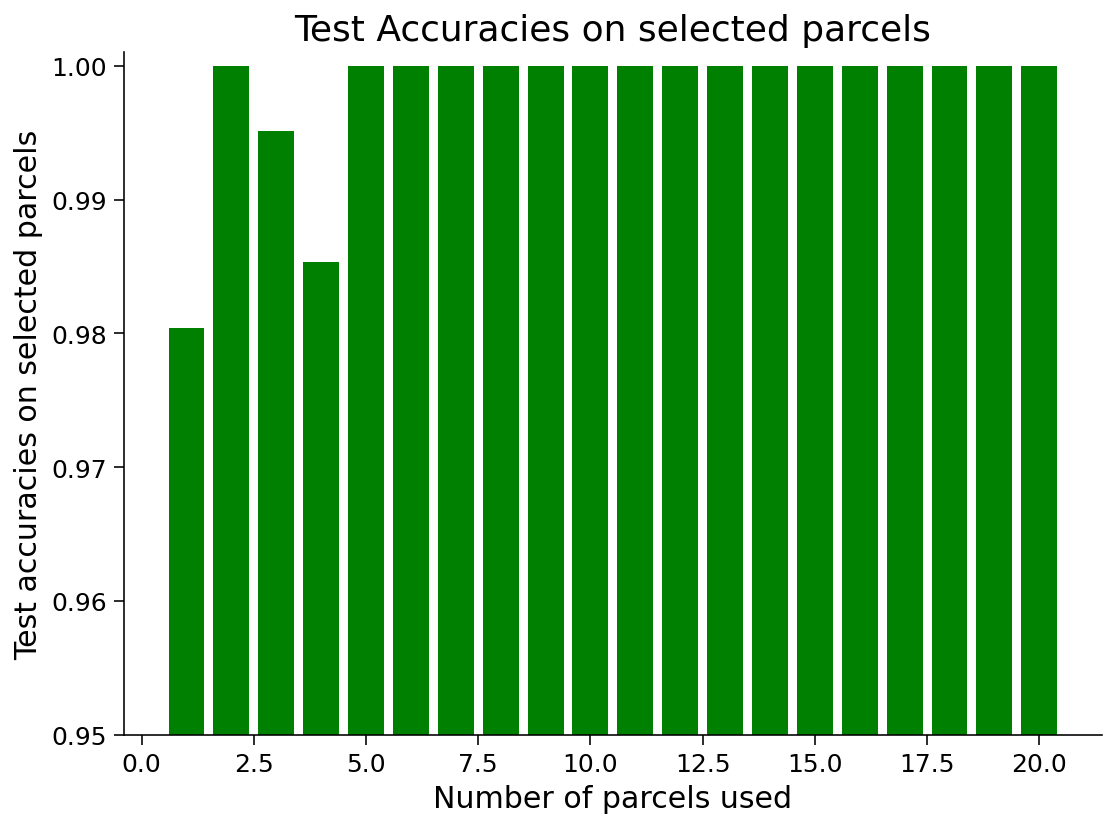

In [ ]:
plt.ylim([0.95,1.001])

plt.title("Test Accuracies on selected parcels")
plt.bar(list(test_accs.keys()), test_accs.values(), color='g', label="Test Accuracies on selected parcels")

plt.xlabel("Number of parcels used")
plt.ylabel("Test accuracies on selected parcels")
# plt.legend(loc='lower left')
# plt.bar(list(random_accs.keys()), random_accs.values(), color='b')
# put them side by side

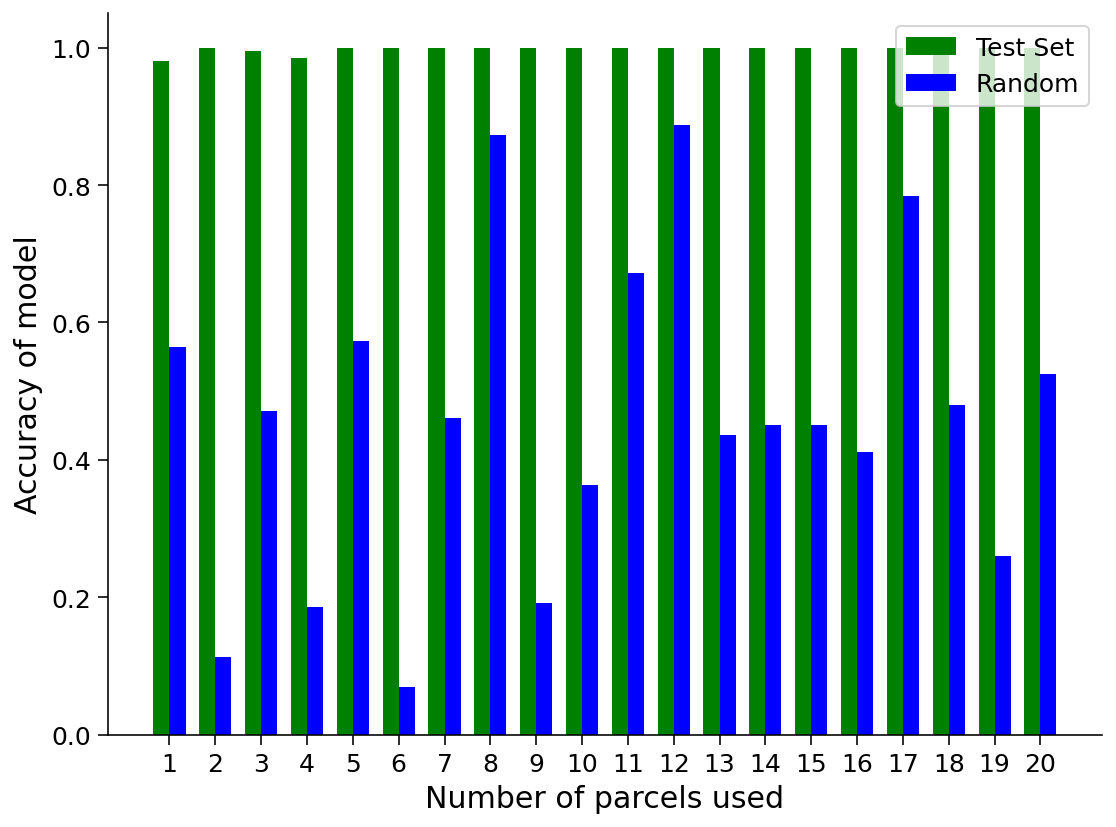

In [ ]:
nums = [i for i in range(N_MAX_PARCELS)]
labels = []
for j in range(len(nums)):
  labels.append(str(nums[j]+1))

test_val_list = list(test_accs.values())
rand_val_list = list(random_accs.values())

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()

rects1 = ax.bar(x - width/2, test_val_list, width, label='Test Set', color='g')
rects2 = ax.bar(x + width/2, rand_val_list, width, label='Random', color='b')

plt.xlabel("Number of parcels used")
plt.ylabel("Accuracy of model")

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

In [ ]:
import scipy
pvalues = []
maxPValue = 1e-50
for i in range(1,20):
    pvalue = scipy.stats.wilcoxon(np.array(prediction_vecs[i], dtype=np.int), prediction_random_vecs[i], zero_method='wilcox', correction=False, alternative='two-sided')
    pvalues.append(pvalue)
    maxPValue = max(maxPValue,pvalue.pvalue)
pvalues, maxPValue

([WilcoxonResult(statistic=44.0, pvalue=8.016692389321367e-20),
  WilcoxonResult(statistic=0.0, pvalue=2.9314535471753785e-41),
  WilcoxonResult(statistic=55.0, pvalue=1.1989467982169688e-24),
  WilcoxonResult(statistic=0.0, pvalue=2.5016196536201745e-37),
  WilcoxonResult(statistic=0.0, pvalue=1.0852117784135296e-20),
  WilcoxonResult(statistic=0.0, pvalue=3.1792965787794205e-43),
  WilcoxonResult(statistic=0.0, pvalue=9.799073841979368e-26),
  WilcoxonResult(statistic=0.0, pvalue=3.414173577297533e-07),
  WilcoxonResult(statistic=0.0, pvalue=9.147659303618332e-38),
  WilcoxonResult(statistic=0.0, pvalue=4.097776494844973e-30),
  WilcoxonResult(statistic=0.0, pvalue=2.7150713219425065e-16),
  WilcoxonResult(statistic=0.0, pvalue=1.62001398246647e-06),
  WilcoxonResult(statistic=0.0, pvalue=7.86974638172278e-27),
  WilcoxonResult(statistic=0.0, pvalue=3.573101894964086e-26),
  WilcoxonResult(statistic=0.0, pvalue=3.573101894964086e-26),
  WilcoxonResult(statistic=0.0, pvalue=6.32606826

In [ ]:
# Clara's code
def load_timeseries_condition(subject, name, runs=None, condition=None, remove_mean=True):

    """Load timeseries data for a single subject in a specified condition.

    Args:
      subject (int): 0-based subject ID to load
      name (str) : Name of experiment ("rest" or name of task) to load
      runs (None or int or list of ints): 0-based run(s) of the task to load,
        or None to load all runs.
      condition (str): Name of the condition that should be tested
      concat (bool) : If True, concatenate multiple runs in time
      remove_mean (bool) : If True, subtract the parcel-wise mean

    Returns
      ts (n_parcel x n_tp array): Array of BOLD data values

    """
    # Get the list relative 0-based index of runs to use
    if runs is None:
        runs = range(N_RUNS_REST) if name == "rest" else range(N_RUNS_TASK)
        evs = load_evs(subject, name, condition)

    elif isinstance(runs, int):
        # load the ev file for the specified run
        evs = load_evs(subject, name, condition)[runs]
        runs = [runs]

    else:
        raise ValueError("'runs'has to be an instance of None of int")

    # Get the first (1-based) run id for this experiment
    offset = get_image_ids(name)[0]

    # Load each run's data
    bold_data = [
        load_single_timeseries(subject, offset + run, remove_mean) for run in runs
    ]

    # Ensure that we have lists of the same length
    if not isinstance(evs, list):
        evs = [evs]
    if len(bold_data) != len(evs):
        print(len(bold_data))
        raise ValueError("Length of `bold_data` and `evs` must match.")

    # get the frames that correspond to events
    frames = condition_frames(evs)

    # select data and save
    selected_data = []
    for run_data, run_frames in zip(bold_data, frames):
        run_frames = run_frames[run_frames < run_data.shape[1]]
        selected_data.append(run_data[:, run_frames])
    selected_data

    return selected_data

In [ ]:
def plot_connectome(connectome_thresh=0.5, connectome_view='MM', show_colormap = False):
    '''
        Plots the connectome for the required tasks.
        params:
            connectome_thresh : threshold below which all correlation values must be suppressed
            connectome_view : (str) what data to represent? accepts 'MM', 'MS' & 'SS' for Math-Math,
                              Math-Story & Story-Story resp.
            show_colormap : Whether to show a colormap of correlation coeffecients.
        returns : None
    '''
    cond_data_math = load_timeseries_condition(0, 'language', runs=0, condition='math', remove_mean=True)[0]
    cond_data_story = load_timeseries_condition(0, 'language', runs=0, condition='story', remove_mean=True)[0]
    least_time_points = min(cond_data_math.shape[1],cond_data_story.shape[1])
    fc_math = np.corrcoef(cond_data_math[:,:least_time_points],cond_data_story[:,:least_time_points])
    if show_colormap:
        plt.imshow(np.array(fc_math), interpolation="none", cmap="bwr", vmin=-1, vmax=1)
        plt.colorbar()
        plt.show()
    if connectome_view == 'MM':
        fc_slice = fc_math[:N_PARCELS,:N_PARCELS]
    if connectome_view == 'MS':
        fc_slice = fc_math[N_PARCELS:,:N_PARCELS]
    if connectome_view == 'SS':
        fc_slice = fc_math[N_PARCELS:,N_PARCELS:]
    fc_slice[fc_slice < connectome_thresh] = 0
    display = plotting.view_connectome(fc_slice, atlas["coords"], edge_threshold="99%")
    plt.show()

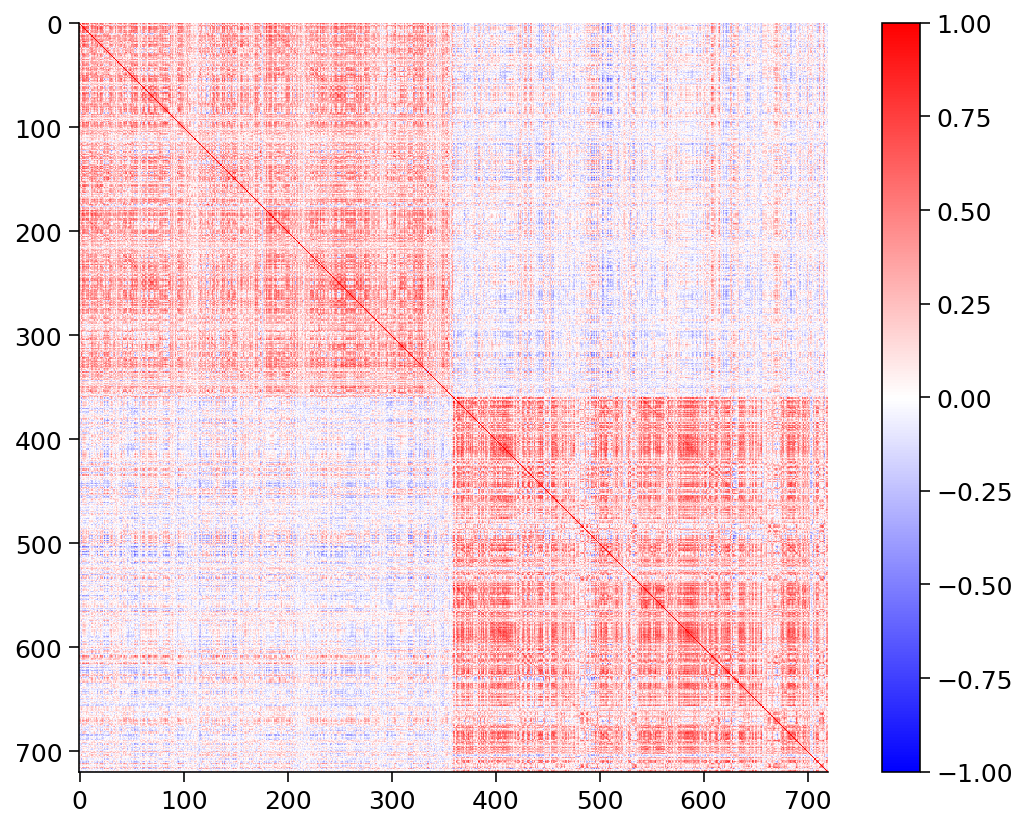

In [ ]:
show_colormap = True
connectome_thresh=0.75
connectome_view='SS'



cond_data_math = load_timeseries_condition(0, 'language', runs=0, condition='math', remove_mean=True)[0]
cond_data_story = load_timeseries_condition(0, 'language', runs=0, condition='story', remove_mean=True)[0]
least_time_points = min(cond_data_math.shape[1],cond_data_story.shape[1])
fc_math = np.corrcoef(cond_data_math[:,:least_time_points],cond_data_story[:,:least_time_points])
if show_colormap:
    plt.imshow(np.array(fc_math), interpolation="none", cmap="bwr", vmin=-1, vmax=1)
    plt.colorbar()
    plt.show()
if connectome_view == 'MM':
    fc_slice = fc_math[:N_PARCELS,:N_PARCELS]
if connectome_view == 'MS':
    fc_slice = fc_math[N_PARCELS:,:N_PARCELS]
if connectome_view == 'SS':
    fc_slice = fc_math[N_PARCELS:,N_PARCELS:]
fc_slice[fc_slice < connectome_thresh] = 0
plotting.view_connectome(fc_slice, atlas["coords"], edge_threshold="99%")

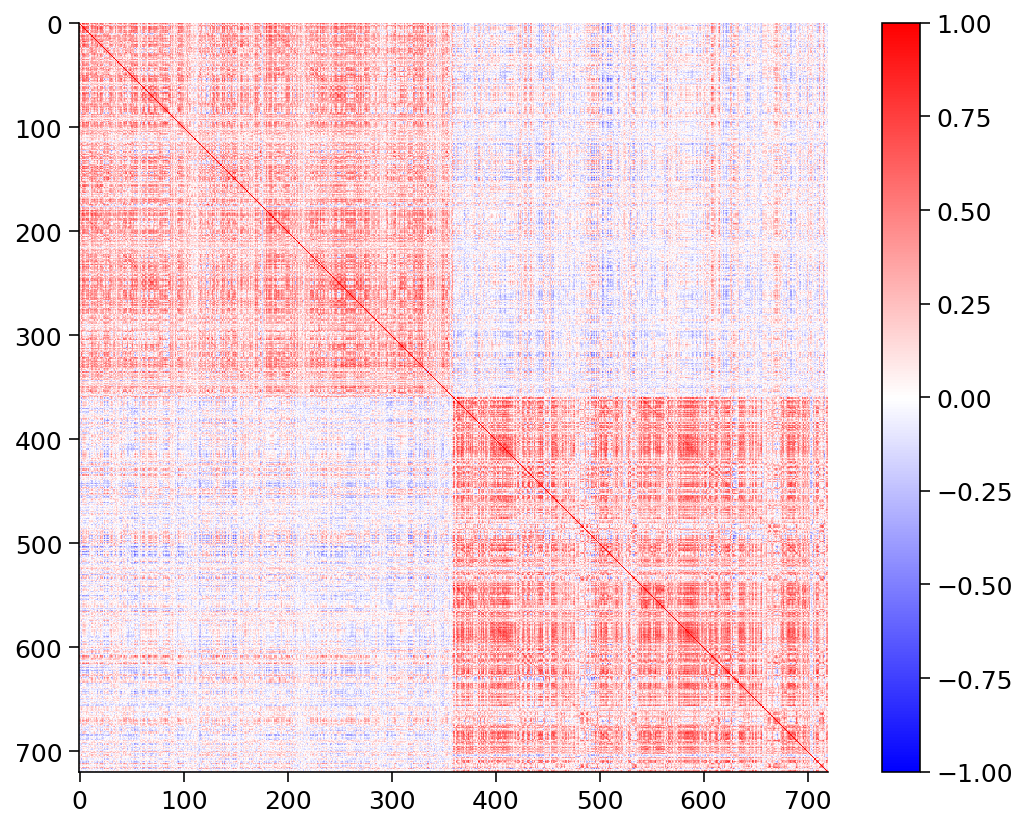

In [ ]:
plot_connectome(0.5,'SS',True)

In [ ]:
# Visualize weight matrices
# FC between story & math
# Cross - Validation**
# Random parcels?**

In [ ]:
for i in range(20):
    random_ind = np.random.choice(np.arange(360),size=2*n_parcels)
    # print(random_ind)
    con_train_math, con_train_story = get_contrasts(np.arange(N_SUBJECTS))
    X,y = create_matrix(con_train_story, con_train_math,random_ind)
    yhat = log_reg.predict(X)
    random_acc = (yhat==y).mean()
    print(f'parcels : {n_parcels}, test acc: {test_acc*100}%, train acc : {train_acc*100}%, random acc : {random_acc*100}%')

parcels : 20, test acc: 100.0%, train acc : 100.0%, random acc : 41.150442477876105%
parcels : 20, test acc: 100.0%, train acc : 100.0%, random acc : 64.15929203539822%
parcels : 20, test acc: 100.0%, train acc : 100.0%, random acc : 44.54277286135693%
parcels : 20, test acc: 100.0%, train acc : 100.0%, random acc : 54.424778761061944%
parcels : 20, test acc: 100.0%, train acc : 100.0%, random acc : 35.10324483775811%
parcels : 20, test acc: 100.0%, train acc : 100.0%, random acc : 44.100294985250734%
parcels : 20, test acc: 100.0%, train acc : 100.0%, random acc : 49.852507374631266%
parcels : 20, test acc: 100.0%, train acc : 100.0%, random acc : 56.63716814159292%
parcels : 20, test acc: 100.0%, train acc : 100.0%, random acc : 15.191740412979351%
parcels : 20, test acc: 100.0%, train acc : 100.0%, random acc : 15.339233038348082%
parcels : 20, test acc: 100.0%, train acc : 100.0%, random acc : 29.793510324483773%
parcels : 20, test acc: 100.0%, train acc : 100.0%, random acc : 48.3

If we choose some random parcels, we get a small accuracy value.


In [ ]:
cross_val_score(log_reg, X,y,cv=8)

array([1.        , 0.98823529, 1.        , 1.        , 1.        ,
       1.        , 1.        , 0.98809524])

In [ ]:
random_ind = np.random.choice(np.arange(360),size=2*n_parcels)
# print(random_ind)
con_train_math, con_train_story = get_contrasts(np.arange(N_SUBJECTS))
X,y = create_matrix(con_train_story, con_train_math,random_ind)
yhat = log_reg.predict(X)
random_acc = (yhat==y).mean()
print(f'parcels : {n_parcels}, test acc: {test_acc*100}%, train acc : {train_acc*100}%, random acc : {random_acc*100}%')

parcels : 20, test acc: 100.0%, train acc : 100.0%, random acc : 11.209439528023598%


In [ ]:
log_reg.coef_

array([[ 0.01731686,  0.00118215,  0.01364996,  0.01496177,  0.01293063,
         0.00680656,  0.01174046,  0.01873923,  0.01051089,  0.01230793,
         0.01412248,  0.01075647,  0.01062512,  0.01536208,  0.00684431,
         0.01013907,  0.01325907,  0.00957881,  0.01078969,  0.01263073,
        -0.01730749, -0.01668912, -0.0064525 , -0.01004481, -0.01654229,
        -0.01716098, -0.00565019, -0.01703399, -0.00021525, -0.01829951,
        -0.01357293, -0.01400643, -0.00807561, -0.0171946 , -0.00909685,
        -0.00259703, -0.01186759, -0.01842702,  0.00849582, -0.01716207]])

In [ ]:
req_ind

array([229, 259, 225, 208,  49,  45,  83, 143, 274, 325, 323,  28,  94,
        79,  95, 324, 296,  30, 262, 116,  87, 267, 164, 344, 355, 307,
        64, 255, 244, 127, 245, 254, 310, 122, 302, 311, 175, 130, 343,
        91])

In [ ]:
regions = np.load(f"{HCP_DIR}/regions.npy").T
region_info = dict(
    name=regions[0].tolist(),
    network=regions[1],
    myelin=regions[2].astype(np.float),
)

In [ ]:
choosen_parcels = []
for i,ind in enumerate(req_ind):
    region_name = region_info['name'][ind]
    region_network = region_info['network'][ind]
    region_myelin = region_info['myelin'][ind]
    choosen_parcels.append({
        'ind' : ind,
        'name' : region_name,
        'network' : region_network,
        'myelin' : region_myelin,
        'weight' : log_reg.coef_[0][i]
    })

In [ ]:
# import pickle
# with open('choosen_parcels.pickle','wb+') as f:
#     pickle.dump(choosen_parcels,f)
choosen_parcels

[{'ind': 229,
  'myelin': 1.83367,
  'name': 'L_MIP',
  'network': 'Language',
  'weight': 0.017316860306563774},
 {'ind': 259,
  'myelin': 1.94169,
  'name': 'L_IFJp',
  'network': 'Frontopariet',
  'weight': 0.0011821519538578978},
 {'ind': 225,
  'myelin': 1.79848,
  'name': 'L_7PL',
  'network': 'Language',
  'weight': 0.013649962769731272},
 {'ind': 208,
  'myelin': 1.77028,
  'name': 'L_7Pm',
  'network': 'Frontopariet',
  'weight': 0.014961771107941096},
 {'ind': 49,
  'myelin': 1.93308,
  'name': 'R_MIP',
  'network': 'Language',
  'weight': 0.012930632613738582},
 {'ind': 45,
  'myelin': 1.88253,
  'name': 'R_7PL',
  'network': 'Language',
  'weight': 0.006806564647029334},
 {'ind': 83,
  'myelin': 1.66882,
  'name': 'R_46',
  'network': 'Cingulo-Oper',
  'weight': 0.011740459757137027},
 {'ind': 143,
  'myelin': 1.86375,
  'name': 'R_IP2',
  'network': 'Frontopariet',
  'weight': 0.018739231511647168},
 {'ind': 274,
  'myelin': 1.86949,
  'name': 'L_LIPd',
  'network': 'Langu

In [ ]:
con_story = get_contrasts(train_subs)
group_contrast = np.mean(con_story,axis=0)

In [ ]:
np.min(atlas['labels_L']),np.max(atlas['labels_L']), np.min(log_reg.coef_[0]), np.max(log_reg.coef_[0])

(-1, 359, -0.018427015754213915, 0.018739231511647168)

In [ ]:
fsaverage = datasets.fetch_surf_fsaverage()
surf_contrast = np.zeros(len(atlas['labels_L']))
# surf_contrast = group_contrast[atlas["labels_L"]]
# Add a threshold, all values above the threshold are pushed to +inf
# surf_contrast[surf_contrast <= thresh] = np.inf
# surf_contrast[0]=np.inf
for parcel in choosen_parcels:
    surf_contrast[parcel['ind']] = parcel['weight']
plotting.view_surf(fsaverage['infl_left'],
                   surf_contrast,
                   vmax=0.03)
# NOT VERY USEFUL ;-;

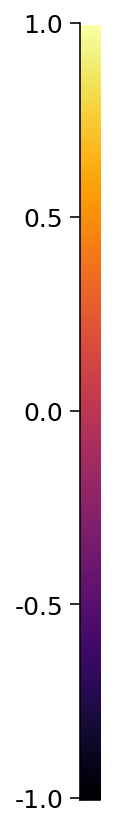

In [ ]:
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))
plt.imshow(gradient.T, cmap=plt.get_cmap('inferno'),aspect=0.3, origin='lower')
plt.yticks([0,64,128,192,256],[-1.0,-0.5,0.0,0.5,1.0])
plt.xticks([])
plt.show()

In [ ]:

image = np.vstack((log_reg.coef_/np.ptp(log_reg.coef_),(group_contrast_math[req_ind]).reshape(1,40)/np.ptp((group_contrast_math[req_ind]).reshape(1,40)),(group_contrast_story[req_ind]).reshape(1,40)/np.ptp((group_contrast_story[req_ind]).reshape(1,40))))
plt.imshow(image, origin='upper', cmap='inferno', aspect="auto")
plt.xlabel('parcel index (First 20 are for maths, next 20 are for story)')
plt.show()
# remove aspect="auto" to change the size
# Automatically normalizes
# plt.show()
# plt.imshow((group_contrast_math[req_ind]).reshape(1,40), origin='lower', cmap='inferno')
# plt.show()
# plt.imshow((group_contrast_story[req_ind]).reshape(1,40), origin='lower', cmap='inferno')
# plt.show()
# plt.bar(np.arange(40)+1, (group_contrast_math[req_ind]))
plt.bar(np.arange(40)+1, (log_reg.coef_[0]))

<BarContainer object of 40 artists>

In [ ]:
np.argmax(log_reg.coef_[0]),np.argmin(log_reg.coef_[0])

(7, 37)